# 2. Calculate travel times

This stage computes the travel times from all the points of a three-dimensional grid to each seismic station. The travel times grid allows for shifting the data according to every tested point source point in the beamforming response calculation.

This tutorial utilizes the `PyKonal` package to compute travel times in a space-dependant velocity medium. The package documentation and installation procedure are described in the [PyKonal package documentation](https://github.com/malcolmw/pykonal). Please acknowledge [White et al. (2020)](https://pubs.geoscienceworld.org/ssa/srl/article-abstract/91/4/2378/586804/PyKonal-A-Python-Package-for-Solving-the-Eikonal?redirectedFrom=fulltext) if using the package.

> **Note:** although `PyKonal` helps calculating the travel times in a three-dimensional velocity model, the example below uses a one-dimensional velocity model.

In [1]:
import numpy as np
import os
import pandas as pd
import pykonal
import tqdm
import xarray as xr

from matplotlib import pyplot as plt

from obspy import read, read_inventory
from pykonal.solver import PointSourceSolver
from pykonal.transformations import geo2sph, sph2geo

## Read velocity model

We downloaded the velocity model of [Karabulut et al. (2011)](https://www.sciencedirect.com/science/article/pii/S0040195111002903?casa_token=wTzEUe0IdicAAAAA:fYbKmGkHHrQfyLicd0lO4Ai451jT6h_yTF6ZZXrvglpw9rXDTVVzWzIWNQ0aFAFbMJ_pU6I) and accessed with `pandas`. The model is given in meters for the depth and in m/s for the speed values. Everything is converted to km for the later compatibility with `pykonal`. 

In [27]:
FILEPATH_VELOCITY = "../data/velocity_model_Karabulut2011.csv"
USE_COLUMNS = {1: "depth", 2: "P", 4: "S"}

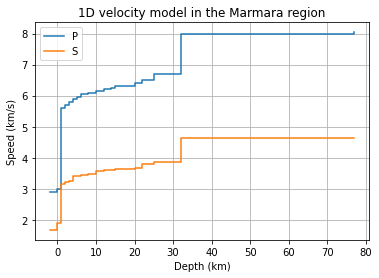

In [28]:
# Read velocity model
velocity_model = pd.read_csv(
    FILEPATH_VELOCITY, 
    usecols=USE_COLUMNS.keys(),
    names=USE_COLUMNS.values(),
    skiprows=1,
    index_col="depth",
    )

# Convert meters to kilometers
velocity_model *= 1e-3
velocity_model.index *= 1e-3

# Plot
ax = velocity_model.plot(drawstyle="steps-post")
ax.set_ylabel("Speed (km/s)")
ax.set_xlabel("Depth (km)")
ax.set_title("1D velocity model in the Marmara region")
ax.grid()
plt.show()


## 3D Grid dimensions

We calculate the travel times on a finer grid than the model grid, so we need to interpolate the model. We do so while keeping the layer aspect of the model (last-value constant interpolation).

In [29]:
# The surface extents are in degrees, the depth positive downwards and in km
WEST, EAST, SOUTH, NORTH, DOWN, UP = 30.20, 30.45, 40.60, 40.76, 30.0, -2.0
GRID_SIZE = N_DEPTH, N_LAT, N_LON = 50, 20, 30

# Depth
depths = np.linspace(UP, DOWN, N_DEPTH)
longitudes = np.linspace(WEST, EAST, N_LON)
latitudes = np.linspace(SOUTH, NORTH, N_LAT)

## Interpolate velocity model at depth

We calculate the travel times on a finer grid than the model grid, so we need to interpolate the model. We do so while keeping the layer aspect of the model (last-value constant interpolation).

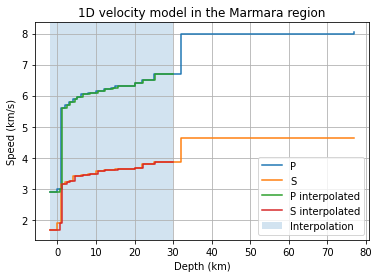

In [63]:
# Interpolate at depth
velocity_model_interp = velocity_model.reindex(depths, method="ffill")

# Plot
velocity_model.plot(drawstyle="steps-post")
velocity_model_interp.plot(
    drawstyle="steps-post",
    xlabel="Depth (km)",
    ylabel="Speed (km/s)",
    title="1D velocity model in the Marmara region",
    ax=plt.gca(),
    grid=True,
)

# Interpolation depth
plt.axvspan(DOWN, UP, alpha=0.2, label="Interpolation range")
plt.legend(["P", "S", "P interpolated", "S interpolated", "Interpolation"])

## Velocity grid in 3D

Because the overall package works in full three-dimensional coordinates, we tile the velocity model into a three-dimensional one. We do that by replicating the 1D along longitude and latitude dimensions with `xarray`.

In [67]:
# Append as xarray
velocities = velocity_model_interp.to_xarray()

# Add longitudes and latitude dimensions
spatial_extension = {"latitude": latitudes, "longitude": longitudes}
velocities = velocities.assign_coords(spatial_extension)

# Tile velocity along new dimensions
for phase in velocities.var():
    velocity = velocities[phase]
    velocity = np.broadcast_to(velocity, (N_LON, N_LAT, N_DEPTH))
    velocity = velocity.transpose(-1, 1, 0)
    velocities[phase] = velocities.dims, velocity

# Show table
velocities

<xarray.Dataset>
Dimensions:    (depth: 50, latitude: 20, longitude: 30)
Coordinates:
  * depth      (depth) float64 -2.0 -1.347 -0.6939 -0.04082 ... 28.69 29.35 30.0
  * latitude   (latitude) float64 40.6 40.61 40.62 40.63 ... 40.74 40.75 40.76
  * longitude  (longitude) float64 30.2 30.21 30.22 30.23 ... 30.43 30.44 30.45
Data variables:
    P          (depth, latitude, longitude) float64 2.9 2.9 2.9 ... 6.7 6.7 6.7
    S          (depth, latitude, longitude) float64 1.67 1.67 1.67 ... 3.85 3.85

## Station coordinates

**Note:** we use the inventory handler of obspy to gather the station coordinates. The `.get_coordinates()` method of the `inventory` object needs a `seed_id` to capture the response or coordinates of a given stream at a given station state in time. This cell gets the first entry of that inventory, noting that for more advanced application this should be handled with care.

In [75]:
# Get inventories
inventory = read_inventory("../data/processed/*xml")

# Get headers
headers = read("../data/processed/*HZ*mseed", headonly=True)

# Create dataframe
network = pd.DataFrame(
    columns=["seed_id", "station", "longitude", "latitude", "depth"], 
    index=range(len(headers))
)

# Loading coordinates from the inventory requires a seed_id (likely because
# of the potential sensor changes over time). Because we did not load any
# stream here, and we are quite confident with this example that the
# station coordinates do not change over a day, we load the first available
# seed id. Note that sometimes a sensor can come with different coordinates
# for different channels (boreholes for instance).
for index, header in enumerate(headers):
    
    coordinates = inventory.get_coordinates(header.id)
    network["seed_id"].iloc[index] = header.id
    network["station"].iloc[index] = header.stats.station
    network["latitude"].iloc[index] = coordinates["latitude"]
    network["longitude"].iloc[index] = coordinates["longitude"]
    network["depth"].iloc[index] = -coordinates["elevation"] * 1e-3

# Show it
network

,seed_id,station,longitude,latitude,depth
0,YH.DC06..BHZ,DC06,30.265751,40.616718,-0.555
1,YH.DC07..BHZ,DC07,30.24217,40.66708,-0.164
2,YH.DC08..BHZ,DC08,30.25013,40.744438,-0.162
3,YH.DD06..BHZ,DD06,30.31777,40.623539,-0.182
4,YH.DE07..BHZ,DE07,30.411539,40.679661,-0.04
5,YH.DE08..BHZ,DE08,30.406469,40.748562,-0.031
6,YH.SAUV..HHZ,SAUV,30.3272,40.7402,-0.17
7,YH.SPNC..BHZ,SPNC,30.3083,40.686001,-0.19


## Show model and stations

Give an overview of the input data.

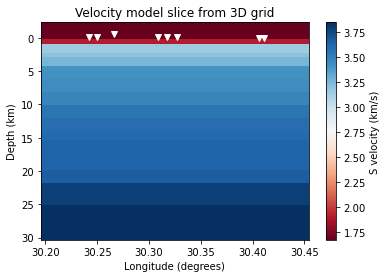

In [85]:
SEISMIC_PHASE = "S"

# Select slice at first latitude index
velocities_slice = velocities[SEISMIC_PHASE].isel(latitude=0)
img = velocities_slice.plot.imshow(cmap="RdBu", add_colorbar=False)

# Add stations
plt.plot(network.longitude, network.depth, "wv")

# Labels
ax = plt.gca() 
ax.set_xlabel("Longitude (degrees)")
ax.set_ylabel("Depth (km)")
ax.set_title("Velocity model slice from 3D grid")
ax.invert_yaxis()

# Colorbar
cb = plt.colorbar(img)
cb.set_label(f"{SEISMIC_PHASE} velocity (km/s)")

# Show 
plt.show()


## Calculate travel times and save

The travel times are calculated for every station with the Eikonal solver of the `pykonal` package. The travel times are then saved into a `h5` file for later use. 

**Warning**: Geographical coordinate system are consider in the $(\lambda, \phi, z)$ order, while the spherical coordinate system uses $(r, \theta, \varphi)$, where $\theta$ and $\varphi$ are in radians, and where $\theta$ is the colatitude, $\lambda$ the latitude and $\phi$ and $\varphi$ are longitudes. The depth $z$ in oriented towards the Earth center, the radial component $r$ outward. 

In [135]:
FILEPATH_TRAVELTIMES = "../data/travel_times.nc"
STATION_ENTRIES = ["latitude", "longitude", "depth"]

# Initiliaze travel times
travel_times = velocities.copy()

# Add a station dimension (travel times calculated per station)
coord = {"station": ("station", network.station)}
travel_times = travel_times.assign_coords(coord)

# Reference point
reference_point = geo2sph((latitudes.max(), longitudes.min(), depths.max()))
node_intervals = (
    depths[1] - depths[0],
    np.deg2rad(latitudes[1] - latitudes[0]),
    np.deg2rad(longitudes[1] - longitudes[0]),
)

for phase in travel_times.var():

    # Initialize grid
    tt = xr.DataArray(coords=travel_times.coords)

    # Loop over stations
    for station_name in tqdm.tqdm(tt.station.data):

        # coordinates = travel_times[STATION_ENTRIES].sel(station=station)
        station_info = network[network.station == station_name]
        station_coords = station_info[STATION_ENTRIES].values

        # Initialize Eikonal solver
        solver = PointSourceSolver(coord_sys="spherical")
        solver.velocity.min_coords = reference_point
        solver.velocity.node_intervals = node_intervals
        solver.velocity.npts = N_DEPTH, N_LAT, N_LON
        solver.velocity.values = velocities[phase][::-1, ::-1].copy()
        solver.src_loc = geo2sph(station_coords).squeeze()

        # Solve Eikonal equation
        solver.solve()

        # Assign to dataarray (flip back for depth convention)
        tt.loc[dict(station=station_name)] = solver.tt.values[::-1, ::-1]

    # Assign to dataset
    travel_times = travel_times.assign({phase: tt})

# Save as nc
travel_times.to_netcdf(FILEPATH_TRAVELTIMES)

# Show how it looks like
travel_times

100%|██████████| 8/8 [00:02<00:00,  2.73it/s]


<xarray.Dataset>
Dimensions:    (depth: 50, latitude: 20, longitude: 30, station: 8)
Coordinates:
  * depth      (depth) float64 -2.0 -1.347 -0.6939 -0.04082 ... 28.69 29.35 30.0
  * latitude   (latitude) float64 40.6 40.61 40.62 40.63 ... 40.74 40.75 40.76
  * longitude  (longitude) float64 30.2 30.21 30.22 30.23 ... 30.43 30.44 30.45
  * station    (station) object 'DC06' 'DC07' 'DC08' ... 'DE08' 'SAUV' 'SPNC'
Data variables:
    P          (depth, latitude, longitude, station) float64 2.084 ... 5.563
    S          (depth, latitude, longitude, station) float64 3.62 ... 9.659

## Show travel times at a given station

The travel times are calculated for every station with the Eikonal solver of the `pykonal` package. The travel times are then saved into a `h5` file for later use.

Text(0.5, 1.0, 'Travel times from the seismic station DC06')

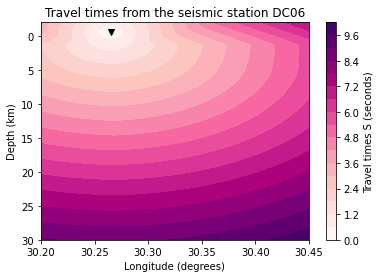

In [139]:
CONTOUR_LEVELS = 20
SEISMIC_PHASE = "S"
STATION_ID = 0
station = network.iloc[STATION_ID]

# Show
latitude_id = np.abs(travel_times.latitude - station.latitude).argmin()
time_delays = travel_times[SEISMIC_PHASE].isel(
    station=STATION_ID, latitude=latitude_id
)
img = time_delays.plot.contourf(
    add_colorbar=False, cmap="RdPu", levels=CONTOUR_LEVELS
)

# Colorbar
cb = plt.colorbar(img)
cb.set_label(f"Travel times {SEISMIC_PHASE} (seconds)")

# Station
plt.plot(station.longitude, station.depth, "kv")

# Labels
ax = plt.gca()
ax.invert_yaxis()
ax.set_xlabel("Longitude (degrees)")
ax.set_ylabel("Depth (km)")
ax.set_title(f"Travel times from the seismic station {station.station}")